In [1]:
import os
import re
import sys
import numpy as np
import nibabel as nb
import ndmg.utils as mgu
from argparse import ArgumentParser
from scipy import ndimage
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from nilearn.plotting.edge_detect import _edge_map as edge_map
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
import pandas as pd
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
import math

init_notebook_mode(connected=True)


def plot_mtx(A, title=""):
    """
    A basic function to plot an adjacency matrix.
    """
    Adf = pd.DataFrame(A).stack().rename_axis(['y', 'x']).reset_index(name="Weight")
    trace = go.Heatmap(x=Adf.x, y=Adf.y, z=Adf.Weight)
    data = [trace]
    layout=go.Layout(width=550, height=550,
                     title=title,
                     xaxis=dict(title="Node Out"),
                     yaxis=dict(title="Node In", autorange="reversed"))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

def opaque_colorscale(basemap, reference, vmin=None, vmax=None, alpha=1):
    """
    A function to return a colorscale, with opacities
    dependent on reference intensities.
    **Positional Arguments:**
        - basemap:
            - the colormap to use for this colorscale.
        - reference:
            - the reference matrix.
    """
    reference = reference
    if vmin is not None:
        reference[reference > vmax] = vmax
    if vmax is not None:
        reference[reference < vmin] = vmin
    cmap = basemap(reference)
    maxval = np.nanmax(reference)
    # all values beteween 0 opacity and 1
    opaque_scale = alpha*reference/float(maxval)
    # remaps intensities
    cmap[:, :, 3] = opaque_scale
    return cmap


def plot_brain(brain, minthr=2, maxthr=95, edge=False):
    brain = mgu.get_braindata(brain)
    cmap = LinearSegmentedColormap.from_list('mycmap2', ['black', 'green'])
    plt.rcParams.update({'axes.labelsize': 'x-large',
                         'axes.titlesize': 'x-large'})
    fbr = plt.figure()
    if brain.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = brain.shape
        x = [int(shap[0]*0.35), int(shap[0]*0.51), int(shap[0]*0.65)]
        y = [int(shap[1]*0.35), int(shap[1]*0.51), int(shap[1]*0.65)]
        z = [int(shap[2]*0.35), int(shap[2]*0.51), int(shap[2]*0.65)]
    coords = (x, y, z)

    labs = ['Sagittal Slice (YZ fixed)',
            'Coronal Slice (XZ fixed)',
            'Axial Slice (XY fixed)']
    var = ['X', 'Y', 'Z']
    # create subplot for first slice
    # and customize all labels
    idx = 0
    min_val, max_val = get_min_max(brain, minthr, maxthr)
    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = fbr.add_subplot(3, 3, idx)
            ax.set_axis_bgcolor('black')
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(brain[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(brain[:, pos, :], 90)
            else:
                image = brain[:, :, pos]

            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0]/2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1]/2, image.shape[1] - 1])

            if edge:
                image = edge_map(image).data
            ax.imshow(image, interpolation='none', cmap=cmap, alpha=1,
                      vmin=min_val, vmax=max_val)

    fbr.set_size_inches(12.5, 10.5, forward=True)
    fbr.tight_layout()
    return fbr


def plot_overlays(atlas, b0, cmaps=None, minthr=2, maxthr=95, edge=False):
    plt.rcParams.update({'axes.labelsize': 'x-large',
                         'axes.titlesize': 'x-large'})
    foverlay = plt.figure()

    atlas = mgu.get_braindata(atlas)
    b0 = mgu.get_braindata(b0)
    if atlas.shape != b0.shape:
        raise ValueError('Brains are not the same shape.')
    if cmaps is None:
        cmap1 = LinearSegmentedColormap.from_list('mycmap1',
                                                  ['black', 'magenta'])
        cmap2 = LinearSegmentedColormap.from_list('mycmap2',
                                                  ['black', 'green'])
        cmaps = [cmap1, cmap2]

    if b0.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = b0.shape
        x = [int(shap[0]*0.35), int(shap[0]*0.51), int(shap[0]*0.65)]
        y = [int(shap[1]*0.35), int(shap[1]*0.51), int(shap[1]*0.65)]
        z = [int(shap[2]*0.35), int(shap[2]*0.51), int(shap[2]*0.65)]
    coords = (x, y, z)

    labs = ['Sagittal Slice (YZ fixed)',
            'Coronal Slice (XZ fixed)',
            'Axial Slice (XY fixed)']
    var = ['X', 'Y', 'Z']
    # create subplot for first slice
    # and customize all labels
    idx = 0
    if edge:
        min_val = 0
        max_val = 1
    else:
        min_val, max_val = get_min_max(b0, minthr, maxthr)

    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = foverlay.add_subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(b0[pos, :, :], 90)
                atl = ndimage.rotate(atlas[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(b0[:, pos, :], 90)
                atl = ndimage.rotate(atlas[:, pos, :], 90)
            else:
                image = b0[:, :, pos]
                atl = atlas[:, :, pos]

            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0]/2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1]/2, image.shape[1] - 1])
            if edge: 
                image = edge_map(image).data
                image[image > 0] = max_val
                image[image == 0] = min_val

            ax.imshow(atl, interpolation='none', cmap=cmaps[0], alpha=.9)
            ax.imshow(opaque_colorscale(cmaps[1], image, alpha=.9,
                      vmin=min_val, vmax=max_val))

    foverlay.set_size_inches(12.5, 10.5, forward=True)
    foverlay.tight_layout()
    return foverlay


def get_min_max(data, minthr=2, maxthr=95):
    '''
    data: regmri data to threshold.
    '''
    min_val = np.percentile(data, minthr)
    max_val = np.percentile(data, maxthr)
    return (min_val.astype(float), max_val.astype(float))


/home/eric/Documents/research/ndmg-repos/env-ndmg/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Comparison of CPAC and NDMG Registered Brains

Below, we compare the CPAC and NDMG registered brains.

I used the coarsest possible version of the Yeo 7 Networks (Yeo7 - Liberal Mask). This means taht we probably include a lot of voxels/regions that aren't actually assigned the corresponding Yeo 7 Network. In future, I will repeat with both coarse and fine of the Yeo 7 Networks.

Also, note the CPAC 200 atlas is upsampled from 3mm to 2mm, whereas CPAC uses it natively at 3mm. I would imagine if we generalized the Yeo networks to a higher resolution parcellation (ie, Glasser) we might do a little better.

In [19]:
%matplotlib inline

ref = nb.load('/data/cmp_cpac_ndmg/ndmg_atlases/atlas/MNI152NLin6_res-2x2x2_T1w_brain.nii.gz')
cpac = ['/data/cmp_cpac_ndmg/cpac/intermediates/0025427_session_1/func_space-MNI_motioncorrect.nii.gz',
       '/data/cmp_cpac_ndmg/cpac/intermediates/0025428_session_1/func_space-MNI_motioncorrect.nii.gz']
ndmg = ['/data/cmp_cpac_ndmg/ndmg/tmp/sub-0025427/ses-1/func/registered/sub-0025427_ses-1_bold_preproc_temp-aligned_skull.nii.gz',
       '/data/cmp_cpac_ndmg/ndmg/tmp/sub-0025428/ses-1/func/registered/sub-0025428_ses-1_bold_preproc_temp-aligned_skull.nii.gz',
       '/data/cmp_cpac_ndmg/ndmg/tmp/sub-0025429/ses-1/func/registered/sub-0025429_ses-1_bold_preproc_temp-aligned_skull.nii.gz']

CPAC Brains at Top in only green; NDMG have the overlay

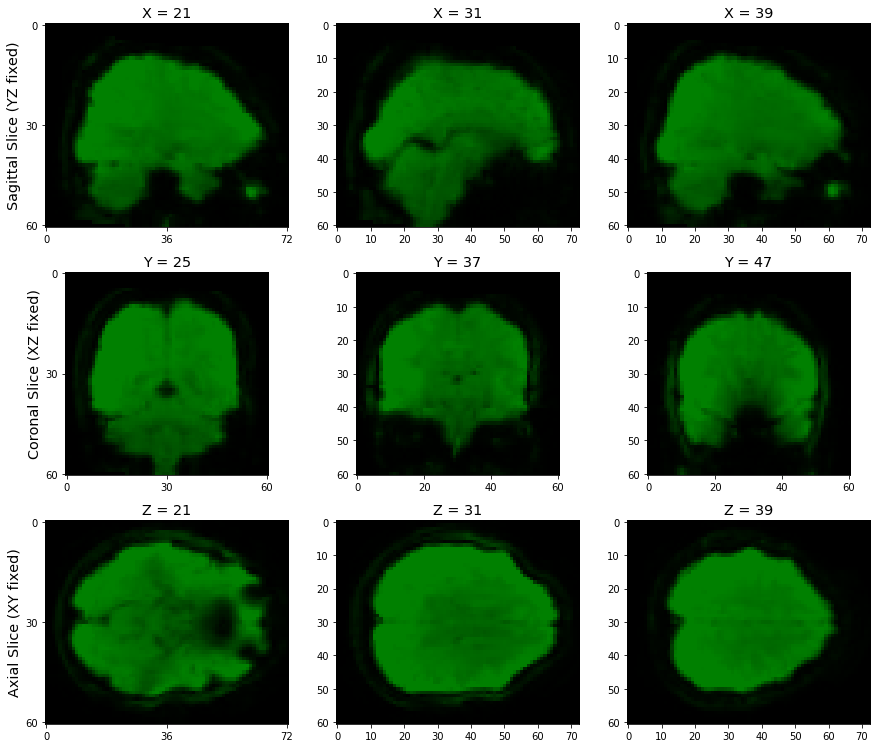

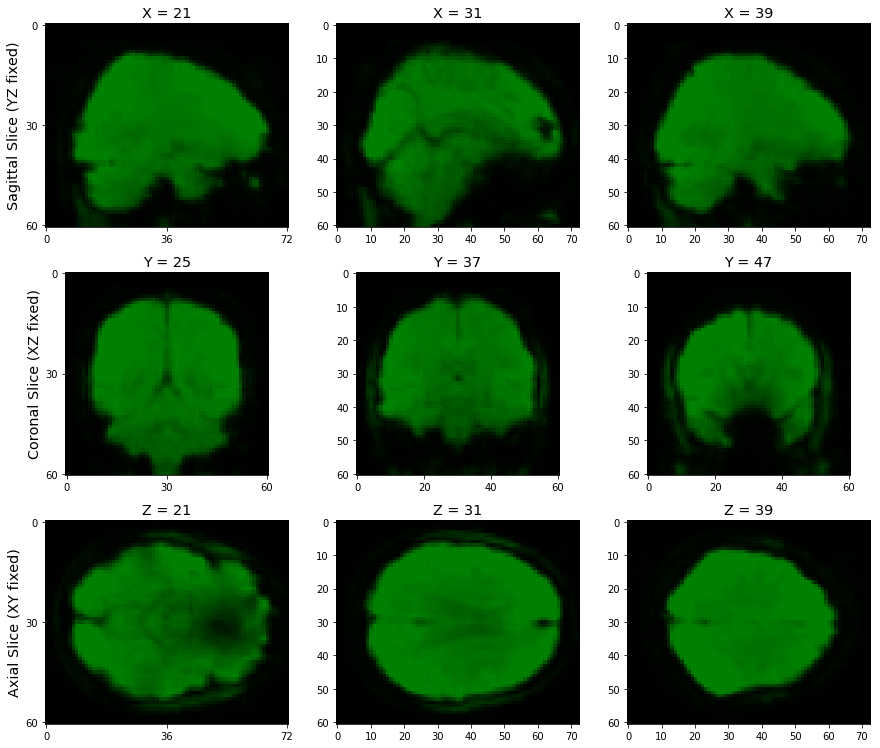

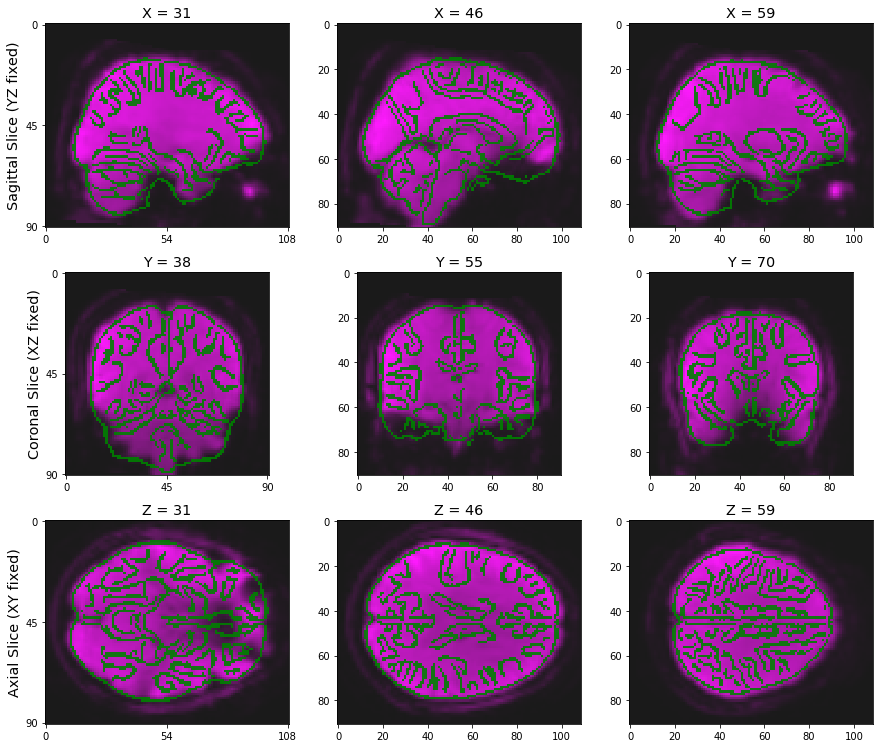

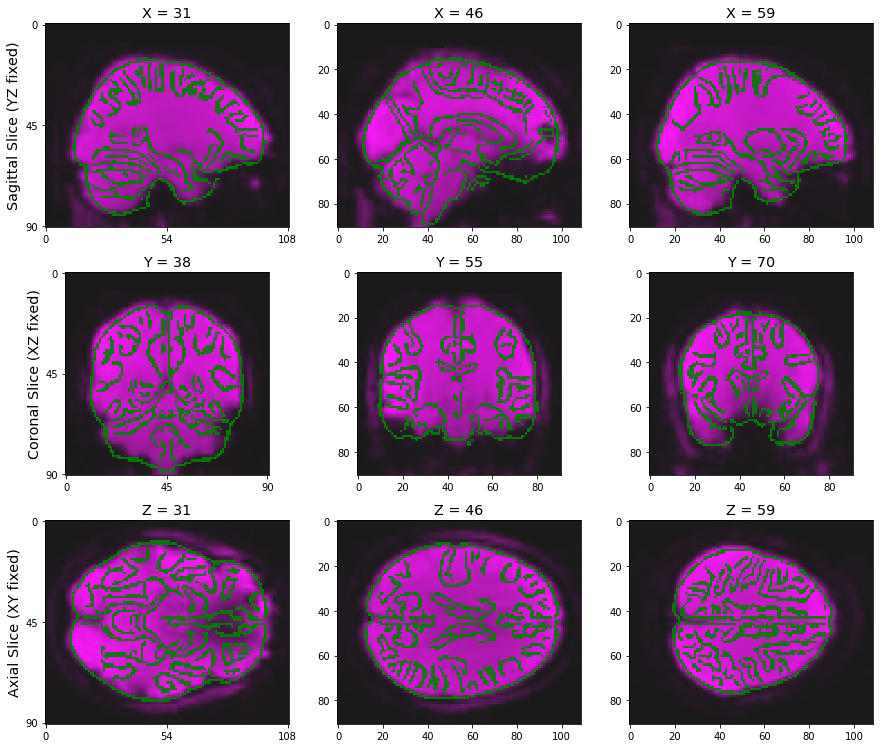

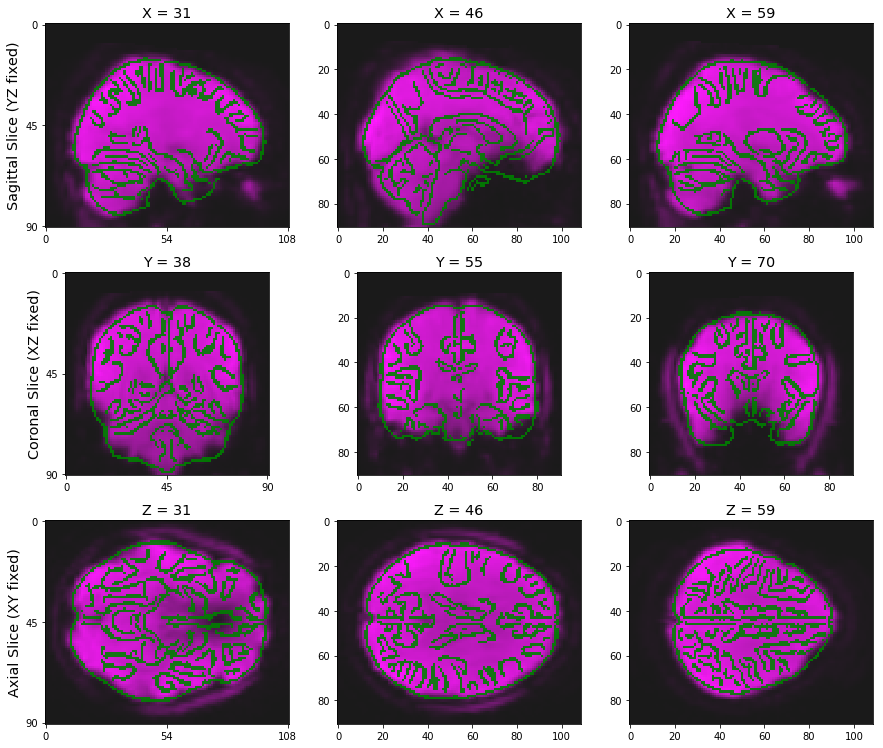

In [20]:
for cpb in cpac:
    cp = nb.load(cpb)
    plot_brain(brain=cp.get_data()[:,:,:,0])

for ndb in ndmg:
    nd = nb.load(ndb)
    plot_overlays(b0=ref, atlas=nd.get_data()[:,:,:,0], edge=True)

In [7]:
cpac_parc = '/data/cmp_cpac_ndmg/ndmg_atlases/label/CPAC200_res-1x1x1.nii.gz'
yeo='/data/cmp_cpac_ndmg/ndmg_atlases/label/test4.nii.gz'
ds_dat = nb.load(cpac_parc).get_data()
anat_dat = nb.load(yeo).get_data()
dsregs = np.unique(ds_dat)
dsregs = dsregs[dsregs > 0]
anatregs = np.unique(anat_dat)

overlapdat = lil_matrix((dsregs.shape[0], anatregs.shape[0]), dtype=np.float32)
for didx, dsreg in enumerate(dsregs):
    dseq = (ds_dat == dsreg)
    N = dseq.sum()
    poss_regs = np.unique(anat_dat[dseq])
    for aidx, anatreg in enumerate(anatregs):
        if (anatreg in poss_regs):
            # percent overlap is dseq and'd with the anatomical region voxelspace, summed and normalized
            pover = np.logical_and(dseq, anat_dat == anatreg).sum()/float(N)
            overlapdat[didx, aidx] = pover

In [8]:
res = overlapdat.toarray()
idx=np.argmax(res, axis=1)

In [9]:
reord = np.argsort(idx)
idxnew = np.sort(idx)

In [10]:
ndmgts = [np.load('/data/cmp_cpac_ndmg/ndmg/func/roi-timeseries/CPAC200_res-2x2x2/sub-0025427_ses-1_bold_CPAC200_res-2x2x2_variant-mean_timeseries.npz'),
          np.load('/data/cmp_cpac_ndmg/ndmg/func/roi-timeseries/CPAC200_res-2x2x2/sub-0025428_ses-1_bold_CPAC200_res-2x2x2_variant-mean_timeseries.npz'),
          np.load('/data/cmp_cpac_ndmg/ndmg/func/roi-timeseries/CPAC200_res-2x2x2/sub-0025429_ses-1_bold_CPAC200_res-2x2x2_variant-mean_timeseries.npz')]

In [11]:
for ts in ndmgts:
    tsf = ts['roi']
    tsreord = tsf[reord[idxnew > 0],:]
    corrmtx = np.corrcoef(tsreord)
    np.fill_diagonal(corrmtx, 0)
    plot_mtx(corrmtx)